# Simulating the Motion of an Optically Trapped Particle

This notebook provides you with a complete code example that loads a set of precalculated optical forces acting on a microsphere held by an optical tweezer and uses it to train a dense neural network to predict the optical forces as a function of the particle position.

## Loading the Data

In [1]:
import os

os.system("git clone https://github.com/DeepTrackAI/optical_forces_dataset")

Cloning into 'optical_forces_dataset'...


0

### Loading the Theoretical Optical Forces

In [2]:
import numpy as np

fz_vs_z_path = os.path.join("optical_forces_dataset", "fz_vs_z_theory.txt")

data_theory = []
with open(fz_vs_z_path, "r") as file:
    for line in file:
        row = []
        for numbers in line.split(","):
            row.append(float(numbers)) 
        data_theory.append(row)
data_theory = np.array(data_theory)

z_theory = data_theory[:, 0]
fz_theory = data_theory[:, 1] * 1e3  # Conversion from pN to fN.

print(f"Theory: {len(z_theory)} positions and {len(fz_theory)} forces")

Theory: 101 positions and 101 forces


### Loading the Geometrical Optics Optical Forces

In [3]:
xyz_go = np.load(os.path.join("optical_forces_dataset", "xyz_go_100rays.npy"))
z_go = xyz_go[50, 50, :, 2]

fxyz_go = np.load(os.path.join("optical_forces_dataset", "fxyz_go_100rays.npy"))
fz_go = fxyz_go[50, 50, :, 2]

print(f"GO: {len(z_go)} positions and {len(fz_go)} forces")

GO: 101 positions and 101 forces


### Comparing the Theoretical and Geometrical Optics Optical Forces 

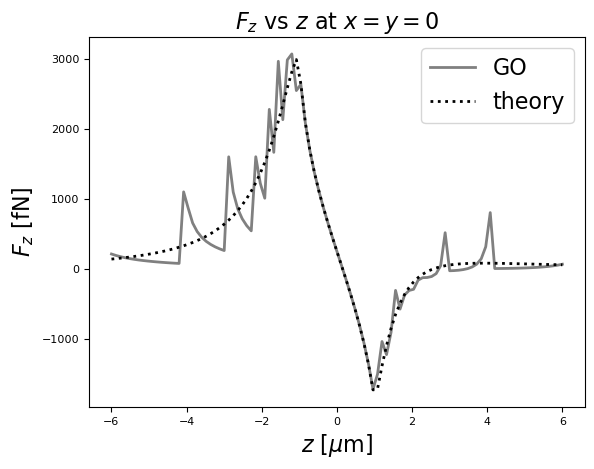

In [4]:
import matplotlib.pyplot as plt

plt.plot(z_go, fz_go, c="gray", linewidth=2, label="GO")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16)
plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.savefig("fig_02_A2.pdf", bbox_inches="tight")  ### plt.show()

## Loading the Training Data

The training data are contained in the files in the directory `sphere_100rays`. There are 101 files with names `force_grid_3D=1.txt`, `force_grid_3D=2.txt`, and so on. Each row in these files consists of eight numbers with the following format: $[R, n_{\rm p}, x, y, z, f_{\rm x}, f_{\rm y}, f_{\rm z}]$, where $R \equiv 1^{−6}\,{\rm m}$ is the particle radius, $n_{\rm p} \equiv 1.5$ is its refractive index, $(x,y,z)$ are its position (in meters), and $(f_{\rm x}, f_{\rm y}, f_{\rm z})$ are its force (in Newtons). 

Write a function to load a data file with optical forces ...

In [5]:
def load_data_file(filename):
    """Load a data file with optical forces."""
    data = []
    with open(filename, "r") as file:
        for line in file: 
            row=[]
            count = 0
            for number in line.split(): 
                if 2 <= count <= 4:
                    row.append(float(number) * 1e6)  # From m to um.
                elif 5 <= count <= 7:
                    row.append(float(number) * 1e15) # From N to fN.
                count += 1
            data.append(row)
    return np.array(data)

... and use it to load all data of the optical forces.

In [6]:
data = np.empty((0, 6)) 
for i in range (1, 102):
    filename = os.path.join("optical_forces_dataset", "sphere_100rays", 
                            f"force_grid_3D={i}.txt")
    data = np.append(data, load_data_file(filename), axis=0)

print(f"{np.shape(data)[0]} data points with {np.shape(data)[1]} variables")

1030301 data points with 6 variables


### Splitting the Data into Training and Validation Datasets

In [7]:
train_split = .80
train_size = int(len(data) * train_split)

np.random.shuffle(data) # In-place shuffle.

data_train = data[:train_size]
xyz_train = data_train[:, :3]
fxyz_train = data_train[:, 3:]

data_val = data[train_size:]
xyz_val = data_val[:, :3]
fxyz_val = data_val[:, 3:]

print(f"{len(xyz_train)} training datapoints")
print(f"{len(xyz_val)} validation datapoints")

824240 training datapoints
206061 validation datapoints


## Implementing the Neural Network

Define the neural network ...

In [8]:
import deeplay as dl

mlp_model = dl.MultiLayerPerceptron(
    in_features=3,
    hidden_features=[256, 256, 256], 
    out_features=3,
).create()

print(mlp_model)
print(f"{sum(p.numel() for p in mlp_model.parameters())} trainable parameters")

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LayerActivationNormalizationDropout(
      (layer): Linear(in_features=3, out_features=256, bias=True)
      (activation): ReLU()
      (normalization): Identity()
      (dropout): Dropout(p=0, inplace=False)
    )
    (1-2): 2 x LayerActivationNormalizationDropout(
      (layer): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
      (normalization): Identity()
      (dropout): Dropout(p=0, inplace=False)
    )
    (3): LayerActivationNormalizationDropout(
      (layer): Linear(in_features=256, out_features=3, bias=True)
      (activation): Identity()
      (normalization): Identity()
      (dropout): Dropout(p=0, inplace=False)
    )
  )
)
133379 trainable parameters


... and compile it.

In [9]:
from torch.nn import MSELoss
from torchmetrics import MeanAbsoluteError

regressor = dl.Regressor(
    mlp_model, 
    loss=MSELoss(), 
    optimizer=dl.Adam(), 
    metrics=[MeanAbsoluteError()],
).create()

print(regressor)

Regressor(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=3, out_features=256, bias=True)
        (activation): ReLU()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
      (1-2): 2 x LayerActivationNormalizationDropout(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (activation): ReLU()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
      (3): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=256, out_features=3, bias=True)
        (

### Implementing Data Loaders

Implement a custom dataset ...

In [10]:
from torch.utils.data import Dataset

class GODataset(Dataset):
    """Geometrical optics dataset."""

    def __init__(self, r, f):
        """Initialize dataset."""
        self.r = r
        self.f = f

    def __len__(self):
        """Return number of position-force couples."""
        return len(self.r)

    def __getitem__(self, i):
        """Get next position-force couple."""
        return (self.r[i].astype(np.float32), self.f[i].astype(np.float32))

... and set up the data loaders for the training and validation data.

In [11]:
train_dataset = GODataset(xyz_train, fxyz_train)
train_dataloader = dl.DataLoader(train_dataset, batch_size=1024)

val_dataset = GODataset(xyz_val, fxyz_val)
val_dataloader = dl.DataLoader(val_dataset, batch_size=1024)

## Training the Neural Network

In [12]:
from lightning.pytorch.loggers import CSVLogger

trainer = dl.Trainer(
    max_epochs=100, 
    accelerator="auto",
    logger=CSVLogger("logs", name="regressor"), 
    log_every_n_steps=20,
)
trainer.fit(regressor, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/regressor

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | MSELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 133 K 
5 | optimizer     | Adam                 | 0     
-------------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


... extract the training metrics ...

In [13]:
import pandas as pd

version = 0

logs = pd.read_csv(os.path.join("logs", "regressor", f"version_{version}",
                                "metrics.csv"))

# Group by epoch and extract train loss and MAE.
train_epoch = logs[logs.train_loss_epoch.notnull()].epoch
train_loss = logs[logs.train_loss_epoch.notnull()].train_loss_epoch 
train_mae = logs[logs.trainMeanAbsoluteError_epoch.notnull()
                 ].trainMeanAbsoluteError_epoch

# Group by epoch and extract val loss and MAE.
val_epoch = logs[logs.val_loss_epoch.notnull()].epoch
val_loss = logs[logs.val_loss_epoch.notnull()].val_loss_epoch 
val_mae = logs[logs.valMeanAbsoluteError_epoch.notnull()
               ].valMeanAbsoluteError_epoch

... and plot the training history.

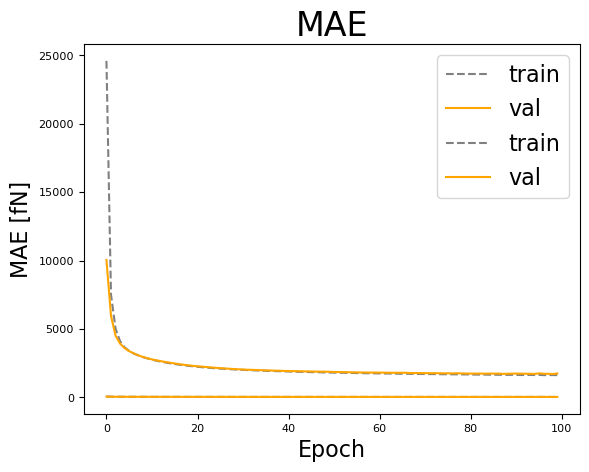

In [14]:
plt.plot(val_epoch, train_loss, label="train", c="gray", linestyle="--")
plt.plot(val_epoch, val_loss, label="val", c="orange")
plt.title("Loss (MSE)", fontsize=24)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss (MSE) [fN$^2$]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.savefig("fig_02_A3a.pdf", bbox_inches="tight")  ### plt.show()

plt.plot(val_epoch, train_mae, label="train", c="gray", linestyle="--")
plt.plot(val_epoch, val_mae, label="val", c="orange")
plt.title("MAE", fontsize=24)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("MAE [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.savefig("fig_02_A3b.pdf", bbox_inches="tight")  ### plt.show()

## Evaluating the Neural Network Performance

Calculate the neural network predictions ...

In [15]:
import torch

positions_nn = torch.zeros((z_theory.shape[0], 3))
positions_nn[:, 2] = torch.from_numpy(z_theory)
positions_nn = positions_nn.to(regressor.device)

forces_nn = regressor(positions_nn).cpu().detach().numpy()
fz_nn = forces_nn[:, 2]

... and plot the comparison of theory, geometrical optics (GO) calculations, and neural network (NN) predictions.

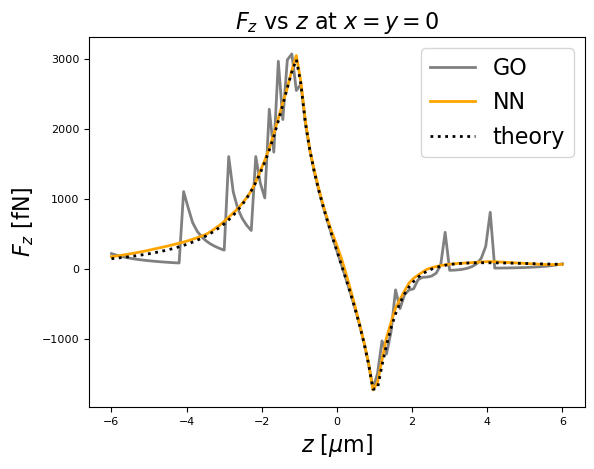

In [16]:
plt.plot(z_go, fz_go, c="gray", linewidth=2, label="GO")
plt.plot(z_theory, fz_nn, c="orange", linewidth=2, label="NN")
plt.plot(z_theory, fz_theory, c="k", linewidth=2, linestyle=":", label="theory")
plt.title("$F_z$ vs $z$ at $x=y=0$", fontsize=16)
plt.xlabel("$z$ [$\mu$m]", fontsize=16)
plt.ylabel("$F_z$ [fN]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.legend(fontsize=16)
plt.savefig("fig_02_A4.pdf", bbox_inches="tight")  ### plt.show()

## Simulating the Motion of an Optically Trapped Particle

100%|██████████| 999/999 [00:00<00:00, 3461.06it/s]


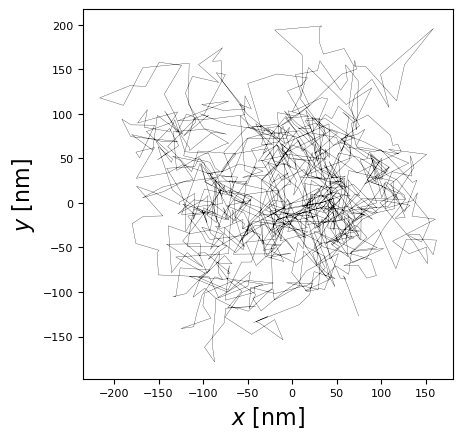

In [17]:
from numpy import pi, sqrt
from tqdm import tqdm

# Parameters.
kB = 1.3806e-23  # Boltzman constant [(kg m^2)/(K s^2)].

laser_power = 1e-3  # Laser power [W].
T = 293  # Absolute temperature [K].
R = 1.0e-6  # Radius [m].
eta = 1e-3  # Viscosity [Pa s].

gamma = 6 * pi * eta * R  # Friction coefficient.
D = kB * T / gamma  # Diffusion coefficient.

N = 1_000  # Number of simulation steps.
delta_t = .001  # Simulation time step [s].

# Simulation.
pos = np.zeros((N, 3))
for t in tqdm(range(N - 1)): 
    pos_t = pos[t:t+1]
    
    pos_t_torch = torch.from_numpy(pos_t).float().to(regressor.device) * 1e6 
    force = regressor(pos_t_torch).cpu().detach().numpy() * 1e-15

    pos[t + 1] = (pos_t
                  + (laser_power / .005) * force / gamma * delta_t
                  + sqrt(2 * D * delta_t) * np.random.normal(0, 1, size=(1, 3)))

# Plot.
plt.plot(pos[:, 0] * 1e+9, pos[:, 1] * 1e+9, "k", linewidth=0.2) 
plt.xlabel("$x$ [nm]", fontsize=16)
plt.ylabel("$y$ [nm]", fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.gca().set_aspect("equal", "box")
plt.savefig("fig_02_A5.pdf", bbox_inches="tight")  ### plt.show()